# LLM

> A module to make direct queries to OpenAI, and eventually other LLMs.

In [2]:
#| default_exp llm

In [3]:
#| hide
from nbdev.showdoc import *

In [48]:
#| export
import os
from dotenv import load_dotenv
import pandas as pd
import openai
import tiktoken
from tqdm import tqdm
import numpy as np
from openai.embeddings_utils import distances_from_embeddings


To run OpenAI, you'll need:
- the openai python library
- an API key, saved as an environment variable

In [5]:
#| export

load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")

With that done, let's try running a test query.

In [6]:
response = openai.Completion.create(model="text-davinci-003", prompt="Say this is a test", temperature=0, max_tokens=7)
response

<OpenAIObject text_completion id=cmpl-6vTYCaBhYWNJuPqzTXo65eGr4bmjU at 0x7f0f9c3482c0> JSON: {
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": null,
      "text": "\n\nThis is indeed a test"
    }
  ],
  "created": 1679156308,
  "id": "cmpl-6vTYCaBhYWNJuPqzTXo65eGr4bmjU",
  "model": "text-davinci-003",
  "object": "text_completion",
  "usage": {
    "completion_tokens": 7,
    "prompt_tokens": 5,
    "total_tokens": 12
  }
}

That worked! That said, the response is in json, so lets extract what seems most relevant, and write that into a function.

In [7]:
response['choices'][0]['text']

'\n\nThis is indeed a test'

Slightly awkward that it's still got a line break in it, but for now, we'll clean that query into a function.

In [8]:
#| export
def query_llm(prompt,model="text-davinci-003"):
    "Given a prompt, will query OpenAI and return the output"
    
    response = openai.Completion.create(model="text-davinci-003", prompt=prompt, temperature=0, max_tokens=7)

    text = response['choices'][0]['text']
    return text


In [9]:
query_llm("What is a bear?")

'\n\nA bear is a large'

That all works! I can now run `nbdev_prepare` to prepare my code to commit.

## Ingesting Data
LLMs don't know anything about how to conduct risk assessments, so we're going to make ours "read" the entirety of [Authorised Professional Practice](https://www.college.police.uk/app/using-app). For now I'm mostly copying this [OpenAI tutorial](https://platform.openai.com/docs/tutorials/web-qa-embeddings).  That's covered in the second notebook, but I've scrapped and clean the College of Policing website.  You can see that in the other module.

In [10]:
df = pd.read_csv("processed/scraped.csv",index_col=0)
df.columns = ['title', 'text']

df

,title,text
0,.police.uk app,.police.uk app. APP (authorised prof...
1,.police.uk,.police.uk. Working together | Coll...
2,.police.uk about,.police.uk about. About us | College...
3,.police.uk about concordats,.police.uk about concordats. Concord...
4,.police.uk about publication scheme,.police.uk about publication scheme. ...
...,...,...
4441,.police.uk cdn cgi l email protection#cb8fedaa...,.police.uk cdn cgi l email protection#cb8fedaa...
4442,.police.uk cdn cgi l email protection#d3b7f5b2...,.police.uk cdn cgi l email protection#d3b7f5b2...
4443,.police.uk cdn cgi l email protection#206f6446...,.police.uk cdn cgi l email protection#206f6446...
4444,.police.uk cdn cgi l email protection#97f4f8f9...,.police.uk cdn cgi l email protection#97f4f8f9...


<Axes: >

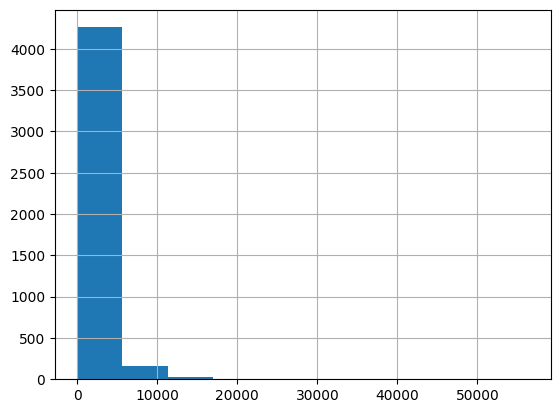

In [11]:
# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")


# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

So we have some very big tokens, that will probably need to be chunked (if only to make our life easier)

In [12]:
#| export
# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = 500):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    


In [13]:
max_tokens = 500


shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

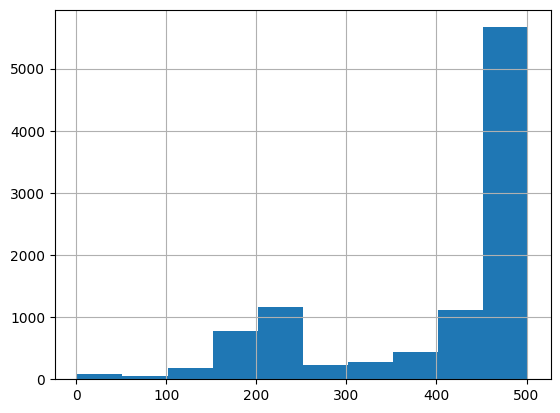

In [14]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

We've now reduced rows into shorted sections under our 500 token limit.

In [15]:
df

,text,n_tokens
0,.police.uk app. APP (authorised prof...,334
1,.police.uk. Working together | Coll...,453
2,.police.uk about. About us | College...,487
3,.police.uk about concordats. Concord...,470
4,.police.uk about publication scheme. ...,291
...,...,...
9970,.police.uk cdn cgi l email protection#cb8fedaa...,218
9971,.police.uk cdn cgi l email protection#d3b7f5b2...,218
9972,.police.uk cdn cgi l email protection#206f6446...,205
9973,.police.uk cdn cgi l email protection#97f4f8f9...,225


In [16]:
df['n_tokens'].sum()

3956090

In total, we have just over 3.5 million tokens.  Based on [OpenAPI pricing](https://openai.com/pricing) is 	$0.0004 / 1K tokens, which means I am *really* not going to be paying much. Let's find out exactly how much.

In [17]:
df['n_tokens'].sum()/1000*0.0004

1.5824360000000002

In [18]:
tqdm.pandas()

In [19]:
df

,text,n_tokens
0,.police.uk app. APP (authorised prof...,334
1,.police.uk. Working together | Coll...,453
2,.police.uk about. About us | College...,487
3,.police.uk about concordats. Concord...,470
4,.police.uk about publication scheme. ...,291
...,...,...
9970,.police.uk cdn cgi l email protection#cb8fedaa...,218
9971,.police.uk cdn cgi l email protection#d3b7f5b2...,218
9972,.police.uk cdn cgi l email protection#206f6446...,205
9973,.police.uk cdn cgi l email protection#97f4f8f9...,225


In [20]:
df['embeddings'] = np.NAN
df

,text,n_tokens,embeddings
0,.police.uk app. APP (authorised prof...,334,NaN
1,.police.uk. Working together | Coll...,453,NaN
2,.police.uk about. About us | College...,487,NaN
3,.police.uk about concordats. Concord...,470,NaN
4,.police.uk about publication scheme. ...,291,NaN
...,...,...,...
9970,.police.uk cdn cgi l email protection#cb8fedaa...,218,NaN
9971,.police.uk cdn cgi l email protection#d3b7f5b2...,218,NaN
9972,.police.uk cdn cgi l email protection#206f6446...,205,NaN
9973,.police.uk cdn cgi l email protection#97f4f8f9...,225,NaN


Given we're going to be putting in lots of requests, we'll break this into chunks of 1000 rows.

In [ ]:
chunked_df = pd.DataFrame()

In [24]:



i = 0 
completed_df = []

while len(chunked_df) < len(df):

    awaits_completing_df = df[~df.index.isin(chunked_df.index.tolist())]
    if len(awaits_completing_df) >= 100:
        sample_size = 100
    else:
        sample_size = len(awaits_completing_df)
    print('remaining length')
    print(len(awaits_completing_df))
    new_chunk = awaits_completing_df.sample(sample_size)
    try:
        new_chunk['embeddings'] = new_chunk.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
        print('completed current chunk')
    except:
        print('chunk failed')
        print('passing')
        new_chunk = pd.DataFrame()
    chunked_df = pd.concat([new_chunk,chunked_df])
    print('completed length')
    print(len(chunked_df))
    chunked_df.to_csv('processed/embeddings.csv')
    i += 1
    print(i)
    

chunked_df

remaining length
75
completed current chunk
completed length
9975
1


,text,n_tokens,embeddings
4431,.police.uk app public order core principles an...,393,"[0.002413947368040681, 0.016671480610966682, -..."
849,To co-create the training with practitioner st...,419,"[-0.010183705948293209, 0.008118431083858013, ..."
6612,The goal of problem analysis is to help you id...,482,"[0.010752184316515923, 0.018526222556829453, 0..."
6068,"Police data, investigation files, and intervie...",384,"[0.01356875617057085, 0.009414355270564556, 0...."
3432,"Of a racialist nature means consisting of, or ...",486,"[-0.012264551594853401, -0.008601714856922626,..."
...,...,...,...
6941,.police.uk cdn cgi l email protection#2d485f47...,203,"[-0.0013092802837491035, -0.01627718284726143,..."
8758,.police.uk article neighbourhood policing week...,484,"[0.003850934561342001, 0.014110091142356396, 0..."
6055,The neighbourhood role also enabled me to prot...,488,"[0.005274541676044464, 0.006226117257028818, -..."
2998,The ABCDE system is as follows. Appearance and...,471,"[-0.008908482268452644, 0.007554392796009779, ..."


That's it!  We've converted our entire library to arrays.

Given we've discovered a bunch of weird failings, let's pack our chunking code into a function

In [25]:

def produce_df_embeddings(df, chunk_size=100):
    """produces embeddings from the open AI api in chunks """

    chunked_df = pd.DataFrame()

    while len(chunked_df) < len(df):

        awaits_completing_df = df[~df.index.isin(chunked_df.index.tolist())]
        if len(awaits_completing_df) >= chunk_size:
            sample_size = chunk_size
        else:
            sample_size = len(awaits_completing_df)
        print('remaining length')
        print(len(awaits_completing_df))
        new_chunk = awaits_completing_df.sample(sample_size)
        try:
            new_chunk['embeddings'] = new_chunk.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
        except:
            print('chunk failed')
            print('passing')
            new_chunk = pd.DataFrame()
        chunked_df = pd.concat([new_chunk,chunked_df])
        chunked_df.to_csv('processed/embeddings.csv')
        i += 1

    
    return chunked_df.sort_index()

## Question Answering
Now we can start building our question answer robot! We start by flatting our embeddings... and actually, we may as well have done that at our earlier step, so lets add it back to that function too.

In [65]:
df = chunked_df.drop_duplicates(subset='text').copy()

df.to_parquet('processed/embeddings.parquet')

In [54]:
df['embeddings'] = df['embeddings'].apply(np.array)

df.head()


,text,n_tokens,embeddings
4431,.police.uk app public order core principles an...,393,"[0.002413947368040681, 0.016671480610966682, -..."
849,To co-create the training with practitioner st...,419,"[-0.010183705948293209, 0.008118431083858013, ..."
6612,The goal of problem analysis is to help you id...,482,"[0.010752184316515923, 0.018526222556829453, 0..."
6068,"Police data, investigation files, and intervie...",384,"[0.01356875617057085, 0.009414355270564556, 0...."
3432,"Of a racialist nature means consisting of, or ...",486,"[-0.012264551594853401, -0.008601714856922626,..."


In [55]:
#| export
def produce_df_embeddings(df, chunk_size=100):
    """produces embeddings from the open AI api in chunks """

    df =  df.drop_duplicates(subset=['text'])

    chunked_df = pd.DataFrame()

    while len(chunked_df) < len(df):

        awaits_completing_df = df[~df.index.isin(chunked_df.index.tolist())]
        if len(awaits_completing_df) >= chunk_size:
            sample_size = chunk_size
        else:
            sample_size = len(awaits_completing_df)
        print('remaining length')
        print(len(awaits_completing_df))
        new_chunk = awaits_completing_df.sample(sample_size)
        try:
            new_chunk['embeddings'] = new_chunk.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
        except:
            print('chunk failed')
            print('passing')
            new_chunk = pd.DataFrame()
        chunked_df = pd.concat([new_chunk,chunked_df])
        chunked_df.to_csv('processed/embeddings.csv')
        i += 1
        
    chunked_df['embeddings'] = chunked_df['embeddings'].apply(np.array)

    
    return chunked_df.sort_index()

In [56]:
#| export
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [57]:
#| export

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [49]:
answer_question(df, question="What day is it?", debug=True)

Context:
.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

.

###

It’s also been raining heavily in the night and we have further calls about flooding in the road, so we ring Highways to inform them. I have a little smile to myself as I remember a call in the summer about cars stopping on the M11 because a mother duck and her ducklings were crossing the road. Lunchtime looms. I’m feeling hungry, but that disappears when I take a call from a 16-year-old male, who tells me that he can’t cope any more. He has cut himself with a knife but he doesn’t want to die. His sister has just had a baby. This goes on an emergency straight away, and officers are dispatched within three minutes. I have to talk to him about anything I can to distract him from his misery – luckily, I am good at small 

"I don't know."

In [50]:
answer_question(df, question="What are the most important factors to consider when searching for a missing person?", debug=True)

Context:
Very detailed information and a lifestyle profile will be needed in high-risk cases consider taking a full statement from the person reporting the missing person as well as any other key individuals (for example, the last person to see them) conduct initial searches of relevant premises, the extent and nature of the search should be recorded (see Search) consider seizing electronic devices, computers, and other documentation, (for example, diaries, financial records and notes) and obtain details of usernames and passwords obtain photos of the missing person; these should ideally be current likeness of the missing person and obtained in a digital format obtain details of the individual’s mobile phone and if they have it with them; if the missing person has a mobile phone arrange for a TextSafe© to be sent by the charity, Missing People obtain details of any vehicles that they may have access to and place markers on relevant vehicles on the PNC without delay consider obtaining a

'It is important to adopt an investigative approach to all reports, ensuring that assumptions are not made about the reasons for going missing. The importance and relevance of risk factors will depend on the circumstances of each case and require investigation to determine if there is a cause for concern. It is also important to record the name and contact details of the person who gave that information and when this happened. Missing people may be at risk of harm resulting from factors such as: an inability to cope with weather conditions, being the victim of violent crime, and risks relating to non-physical harm, for example, the people they are with, the places or circumstances they are in.'

Now, let's tweak to answer sergeant exam questions, and see how it does.

In [60]:
#| export

def answer_sergeant_exam_question(
    df,
    question,
    model="text-davinci-003",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """

    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )

    exam_prompt= f""" Answer the question below, in the format 'The answer is X because Z', where X is the letter of the correct answer (A,B,C or D) and X is the explanation in fewer than 3 sentences. 

    if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:"""

    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=exam_prompt,
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

Let's answer a question from here
https://www.how2become.com/blog/police-sergeants-inspectors-exam/


In [61]:
question = """ Officer Jennings is on his evening patrol. He is just about to finish for the day. As he walks down the street, he is approached by a man named Mark, who claims that he saw a man (named Steven) driving down a road not far from the location. Mark claims that he saw Steven drive into a cyclist, before driving off without stopping. Luckily, the cyclist was unharmed. The cyclist was named Kevin. Mark spoke to Kevin, and discovered that he is a 42 year old man, with a wife and two daughters.

Fifteen minutes later, Officer Jennings manages to stop the car being driven by Steven. He pulls him over to the side of the road, and orders him to step out of the car.

 

Referring s.6 (5) of the Road Traffic Act 1988, is Officer Jennings within his legal rights to order that Steven takes a preliminary breath test?

A – No. Officer Jennings has no right to tell Steven what he can and can’t do. He should never have stopped Steven in the first place.

B – No. In order for Officer Jennings to do this, an accident must have happened. The fact that Officer Jennings suspects an accident has taken place, does not meet this requirement.

C – Yes. However, the breath test must take place within or close to an area where the requirements for Steven to cooperate, can be imposed.

D – Yes. Officer Jennings can tell Steven to do whatever he wants, as he’s a police officer."""

answer_sergeant_exam_question(df,question)

'B - No. In order for Officer Jennings to do this, an accident must have happened. The fact that Officer Jennings suspects an accident has taken place, does not meet this requirement.'

Sadly, the correct answer is C.... so no luck.

In [62]:
question = """Sarah is walking to work one morning, when she is approached from behind by Henry and Jacob.

‘We won’t hurt you, as long as you give us the bag,’ Henry says.

‘You’re not getting it!’ Sarah shouts.

Henry grabs Sarah and holds a knife to her throat, whilst Jacob tries to snatch her bag.

Sarah fights with her attackers, and begins to run away. As the two men chase her, she trips and bangs her head on the pavement. She is taken to hospital and dies from head trauma.

Based on the above information, which of the following options is correct?

A – Jacob cannot be held accountable for the death of Sarah, as he simply tried to take her bag.

B – Jacob and Henry will be charged with attempted robbery, but not in the death of Sarah.

C – Jacob and Henry could be considered liable for the death of Sarah.

D – Sarah’s death cannot be blamed on Henry and Jacob, as it was her choice to run away."""

answer_sergeant_exam_question(df,question)

'C - The answer is C because Jacob and Henry could be considered liable for the death of Sarah, as they were the ones who initiated the attack and chased her, which led to her tripping and hitting her head.'

That's one point for BotCop! Not the most reliable explanation of all time, but given this wasn't trained on APP, I'm not surprised.

Lets do one more, from here

https://www.riddle.com/embed/q/iframe/fi9xdWl6emVzLzQ2OTgwNw

In [63]:
question = """PC DRAPER is called to the scene of a robbery. The property stolen in the offence consists of a gold ring and a gold watch. The victim identifies BROWN as the offender and provides a description of BROWN to PC DRAPER. BROWN’s details are circulated along with a warning that BROWN is known to be a violent drug dealer who has attempted to stab officers with hypodermic needles in the past. Shortly after the circulation, DCs HEMMINGWAY and LE FORT see BROWN standing outside a busy shopping centre. The officers stop BROWN and arrest him for the robbery offence. The officers propose to search BROWN at the location of the arrest under s. 32 of the Police and Criminal Evidence Act 1984.

Which of the following statements is correct in respect of this power?

A - The officers could search BROWN but only for the stolen property.
B - This power would not authorise the search of BROWN’s mouth.
C - Such a search could involve BROWN being required to take off his shoes.
D - The officers could search the location where BROWN was arrested."""

answer_sergeant_exam_question(df,question)

"B - This power would not authorise the search of BROWN’s mouth because section 32 of the Police and Criminal Evidence Act 1984 only authorizes the search of a person's clothing and anything in their possession."

So the answer was apparently D... but once again, it sounds vaguely plausible?

In [77]:
#| export

def conduct_risk_assessment(
    df,
    question,
    model="text-davinci-003",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """

    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )

    missing_risk_prompt = f""" Using the information below on a missing person, decide on the appropriate risk grading for the person, from either
- High risk
- Medium risk
- Low risk
- no apparent risk

Return your answer in the format: 'Graded as X risk, because of the below risk factors:
- Y
- Z'

Where X is your risk grading (high, medium, low, or no apparent risk) and Y and Z are a few sentences explaining the most important risks you have identified.

if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:""",

    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=missing_risk_prompt,
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [69]:
risk_profile = """John Smith is a 31 year old man who has been missing for 5 hours. He went to work as normal this morning, and has not returned home, and his partner is concerned. There are no signs of foul play, no vulnerabilities. John is in good health, the weather is good, and there are no concerns for his welfare."""


conduct_risk_assessment(df, risk_profile, debug=True)

'Graded as Low risk, because of the below risk factors:\n- John is an adult, and there are no signs of foul play or vulnerabilities\n- He is in good health, and the weather is good\n- There are no concerns for his welfare'

In [78]:
jason_risk_profile = """ Jason is a 15 year old adult male, who has gone missing from his care home in Southwark. His carer has contacted the school, which has said he was not in today.
They that this is not the first time, and that Jason has been seen hanging out with older boys, who may be involved in crime and drugs."""


conduct_risk_assessment(df, jason_risk_profile, debug=True)

Context:
 First published 22 November 2016  Updated 15 March 2023   Latest changes  Written by College of Policing  Missing persons  30 mins read   Implications for the UK leaving the European Union are currently under review – please see APP on international investigation for latest available detail on specific areas, for example: Schengen Information System Europol INTERPOL Joint Investigation Teams This section provides additional information to aid the investigation based on the vulnerability of the individual and the circumstances in which they are missing. Missing children Safeguarding young and vulnerable people is a responsibility of the police service and partner agencies (see Children Act 2004). When the police are notified that a child is missing, there is a clear responsibility on them to prevent the child from coming to harm. Where appropriate, a strategy meeting may be held. For further information see: Voice of the child  Voice of the child practice briefing  Section 11 

'Graded as Medium risk, because of the below risk factors:\n- Jason is a 15 year old adult male, who has gone missing from his care home in Southwark\n- This is not the first time he has gone missing\n- He has been seen hanging out with older boys, who may be involved in crime and drugs'

In [79]:
margaret_risk_profile = """ Margaret is a 97 year old woman with severe dementia from Twickenham. She lives in supported accomodation, but regularly goes missing, as she walks out when left unsupervised.

She has been missing 6 hours, and it is now 2200.  It is getting dark, and staff are saying she is rarely missing this long"""


conduct_risk_assessment(df, margaret_risk_profile, debug=True)

Context:
.police.uk research projects maximizing effectiveness police scotland investigations when people living dementia go missing.            Maximizing the effectiveness of Police Scotland investigations when people living with dementia go missing | College of Policing             Sorry, you need to enable JavaScript to visit this website.    Skip to content Jump to search         Menu      Secondary navigation About us News & views Contact us  Search Search     Main navigation Policing guidance Research Career & learning Support for forces Ethics     Breadcrumb Home Research Research projects map           Maximizing the effectiveness of Police Scotland investigations when people living with dementia go missing            Maximizing the effectiveness of Police Scotland investigations when people living with dementia go missing         On this page     This research aims to explore the effectiveness of searches for people living with dementia who are reported as missing. Key detail

'Graded as High risk, because of the below risk factors:\n- Margaret is 97 years old and has severe dementia, making her more vulnerable to harm\n- She has been missing for 6 hours, which is longer than usual, and it is now dark outside, increasing the risk of harm'

The model works.  I'm happy with it.  So let's tie it into a function we can deploy as a web app.

In [84]:
#| export

def machine_risk_assessment(
    question,
    df,
    model="text-davinci-003",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """

    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )

    missing_risk_prompt = f""" Using the information below on a missing person, decide on the appropriate risk grading for the person, from either
- High risk
- Medium risk
- Low risk
- no apparent risk

Return your answer in the format: 'Graded as X risk, because of the below risk factors:\n - Y \n - Z \n'

Where X is your risk grading (high, medium, low, or no apparent risk) and Y and Z are a few sentences explaining the most important risks you have identified.

if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:""",

    # If debug, print the raw model response

    
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=missing_risk_prompt,
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )

        answer = response["choices"][0]["text"].strip()
        
        return answer, context
    except Exception as e:
        print(e)
        return ""

In [89]:
about_yannik = """ Yannik is a 15 year old boy. He has recently been down, and was reported missing by his parents as he did not return home from school today.

His friends are worried he may be depressed, and when he apparently told one a few days ago 'if it doesn't get any better, I'm going to end it soon'
"""

yannik_answer, yannik_context = machine_risk_assessment(about_yannik, df)
yannik_answer

'Graded as High risk, because of the below risk factors: \n- Yannik is a 15 year old boy who has been reported missing by his parents\n- His friends are worried he may be depressed\n- He has expressed suicidal ideation to one of his friends'

In [90]:
yannik_context

" First published 22 November 2016  Updated 15 March 2023   Latest changes  Written by College of Policing  Missing persons  30 mins read   Implications for the UK leaving the European Union are currently under review – please see\xa0APP\xa0on international investigation\xa0for latest available detail on specific areas, for example: Schengen Information System Europol INTERPOL Joint Investigation Teams This section provides additional information to aid the investigation based on the vulnerability of the individual and the circumstances in which they are missing. Missing children Safeguarding young and vulnerable people is a responsibility of the police service and partner agencies (see\xa0Children Act 2004). When the police are notified that a child is missing, there is a clear responsibility on them to prevent the child from coming to harm. Where appropriate, a strategy meeting may be held. For further information see: Voice of the child\xa0 Voice of the child practice briefing\xa0 S

It works!

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()